In [1]:
############# live plotting code #############
#https://qcodes.github.io/Qcodes/examples/DataSet/Measuring%20X%20as%20a%20function%20of%20time.html
#import all needed functions ext
import os
import numpy as np
import qcodes as qc
import IPython.lib.backgroundjobs as bg
from plottr.apps import inspectr
from zhinst.qcodes import UHFLI
from qcodes import Parameter, Station
import matplotlib.pyplot as plt
from qcodes.parameters import ElapsedTimeParameter, Parameter
from qcodes.dataset import (
    Measurement,
    do1d,
    do2d,
    initialise_or_create_database_at,
    load_or_create_experiment,
    plot_dataset,
    connect,
    experiments,
    get_default_experiment_id,
    load_experiment,
    load_experiment_by_name,
    load_last_experiment,
    new_data_set,
    new_experiment,
    reset_default_experiment_id,
    DataSetType,
    load_by_run_spec,
)

#location for saving data
local=r"H:\Uni\Physics\PhD\Year_2\CNT experiment\Fork\Code\TrackFreqeuncy\TestData"
#Start tracking of measurements
qc.logger.start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\Hender12\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\Hender12\.qcodes\logs\231006-18024-qcodes.log


In [2]:
#Create a database to store all measured data relating to this experiment
db_file_path = os.path.join(local, 'Frequency_Tracking.db')
initialise_or_create_database_at(db_file_path)
exp = load_or_create_experiment(experiment_name='Experiment Name', sample_name="Air1D")

In [3]:
# Create an instance of UHFLI - the real instriment which this code connects to
lockin = UHFLI(name='lockin', serial='dev2436', host='localhost')
station = qc.Station(lockin)

2023-10-06 14:29:42,474 ¦ zhinst.toolkit.driver.devices.uhfli ¦ ERROR ¦ uhfli ¦ awgs ¦ 24 ¦ Missing option: AWG


In [4]:
jobs = bg.BackgroundJobManager()
jobs.new(inspectr.main, db_file_path)

<BackgroundJob #0: <function main at 0x0000022E07D1CAF0>>

In [5]:
#To controle the instriments we need to create correct/find comands
#I have a set command to set or get the frequency
lockin.oscs[0].freq.set(32.75e3) #set command #32.75e3Hz is an example freq
def frequencyget(): #Get comand
    return(lockin.snapshot()["submodules"]["oscs"]["channels"]["lockin_oscs0"]["parameters"]["freq"]["raw_value"])
#Here is the equivilent comand for measured amplitude x, y and r
def getampx():
    return(float(lockin.demods[0].sample()["x"]))
def getampy():
    return(float(lockin.demods[0].sample()["y"]))

In [6]:
#set the voltage signal value
lockin.sigouts[0].imp50.set(0)
lockin.sigouts[0].amplitudes[3].value(0.5) #0.75 max
lockin.sigins[0].range(0.8)
lockin.demods[3].timeconstant(52.37e-3)
#Now turn on the measurement setup and turn on the voltage signal
lockin.sigouts[0].on(True)
lockin.demods[0].enable()

</dev2436/demods/0/enable.on: 1>

In [7]:
time = ElapsedTimeParameter('time')
# Define a QCoDeS parameter for the frequency
frequency_parameter = Parameter('Frequency', unit="Hz", get_cmd=frequencyget, set_cmd=lockin.oscs[0].freq.set)
Amplitude_parameterx= Parameter('X_Amplitude', unit="V", get_cmd=getampx)
Amplitude_parametery = Parameter('Y_Amplitude', unit="V", get_cmd=getampy)

In [8]:
#A file containing all the functions to allow the data to be fitted
%run ./FittingFunctions.ipynb

#Functions to find the frequency of resonance in some data given
#There plus the functions they call can be updated to move the frequency range to follow the resoance if it moves
#There should also be a manuel way to change this range
def Track_Maxr_freq():
    start_frequency = 32.70e3  # Hz
    end_frequency = 32.835e3  # Hz
    num_points = 60
    delay=0.1
    return(getfreq2(start_frequency,end_frequency,num_points,delay))

def Track_Fitted_freq():
    start_frequency = 32.70e3  # Hz
    end_frequency = 32.835e3  # Hz
    num_points = 60
    delay=0.1
    return(getfreq(start_frequency,end_frequency,num_points,delay,False))

In [9]:
time = ElapsedTimeParameter('time')
# Define a QCoDeS parameter for the frequency
frequency_parameter = Parameter('Frequency', unit="Hz", get_cmd=frequencyget, set_cmd=lockin.oscs[0].freq.set)
Amplitude_parameterx= Parameter('X_Amplitude', unit="V", get_cmd=getampx)
Amplitude_parametery = Parameter('Y_Amplitude', unit="V", get_cmd=getampy)
#Parameters for the frequency tracking
Max_freq_parameter=Parameter('Max_Freq', unit="Hz", get_cmd=Track_Maxr_freq)
Fitted_freq_parameter=Parameter('Fitted_Freq', unit="Hz", get_cmd=Track_Fitted_freq)
time = ElapsedTimeParameter('time')

In [10]:
meas = Measurement()
meas.register_parameter(time)
meas.register_parameter(Max_freq_parameter, setpoints=[time])

In [12]:
#This could be turned into a do 2D measurement perhaps now? I am unsure as it only tracks one number
meas = Measurement()
meas.register_parameter(time)
meas.register_parameter(Max_freq_parameter, setpoints=[time])
meas.register_parameter(Fitted_freq_parameter, setpoints=[time]) #Could track this one also but I think looking for the maximum is faster.

with meas.run() as datasaver:
    time.reset_clock()
    for _ in range(3): #(9 measurements takes ~100s)
        now = time()
        plt.rcParams["font.family"] = "Arial"
        datasaver.add_result((Max_freq_parameter, Max_freq_parameter()), (Fitted_freq_parameter, Fitted_freq_parameter()), (time, now)) #Tracks both
        #datasaver.add_result((Max_freq_parameter, Max_freq_parameter()), (time, now))
dataset = datasaver.dataset

Starting experimental run with id: 6. 
Starting experimental run with id: 7. Using 'qcodes.dataset.do1d'
Starting experimental run with id: 8. Using 'qcodes.dataset.do1d'
Starting experimental run with id: 9. Using 'qcodes.dataset.do1d'
Starting experimental run with id: 10. Using 'qcodes.dataset.do1d'
Starting experimental run with id: 11. Using 'qcodes.dataset.do1d'
Starting experimental run with id: 12. Using 'qcodes.dataset.do1d'


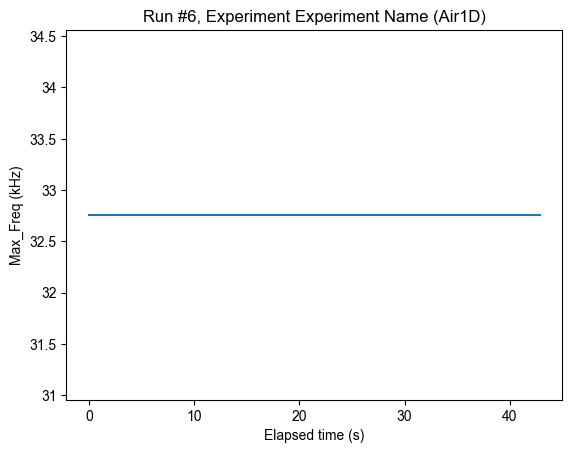

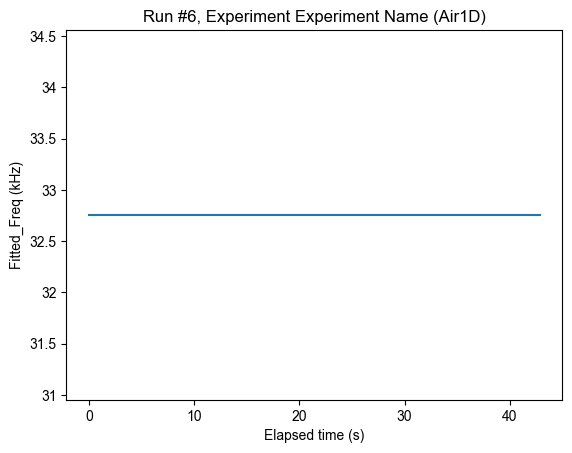

In [13]:
plt.rcParams["font.family"] = "Arial"
axs, cbs = plot_dataset(dataset)